## Group ID
ADL Group 75


## Group Members
1. Ravindra Kumar Tholiya - 2023AA05124
2. Jahnavi Gali - 2023AA05684
3. Shivam Sahil - 2023AA05663
4. Chakshu - 2023aa05280

# Task 1: Implement and train a conditional Wesserstein GAN with CIFAR10 dataset. Generate and display 10 new images belonging to 'automobile' class. Report IS and FID scores.



In [6]:
# Necessary Imports
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm

In [7]:
!pip install torchmetrics
!pip install torch-fidelity
!pip install torchmetrics[image]

In [8]:
from torchmetrics.image.inception import InceptionScore
from torchmetrics.image.fid import FrechetInceptionDistance

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [10]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [30]:
# Hyperparameters
batch_size = 64
image_size = 32
channels = 3
num_classes = 10
latent_dim = 100
embedding_dim = 50
num_epochs = 1000
lr = 1e-4
beta1 = 0.0
beta2 = 0.9
lambda_gp = 10    # Gradient penalty lambda
n_critic = 5      # Number of critic iterations per generator iteration

In [31]:
# Data loading and preprocessing: Normalize images to [-1, 1] (to match tanh output)
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

In [32]:
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

Files already downloaded and verified


In [33]:
# Define the Generator network
class Generator(nn.Module):
    def __init__(self, latent_dim, num_classes, embedding_dim, channels=3, feature_map_size=64):
        super(Generator, self).__init__()
        self.label_emb = nn.Embedding(num_classes, embedding_dim)
        self.init_size = image_size // 4  # initial size before upsampling (e.g., 8 for 32x32)
        self.l1 = nn.Sequential(nn.Linear(latent_dim + embedding_dim, feature_map_size * 2 * self.init_size ** 2))

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(feature_map_size * 2),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(feature_map_size * 2, feature_map_size, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(feature_map_size, 0.8),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(feature_map_size, channels, kernel_size=3, stride=1, padding=1),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        # Embed labels and concatenate with noise
        label_embedding = self.label_emb(labels)
        gen_input = torch.cat((noise, label_embedding), -1)
        out = self.l1(gen_input)
        out = out.view(out.shape[0], -1, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img


In [34]:
# Define the Discriminator (Critic) network
class Discriminator(nn.Module):
    def __init__(self, num_classes, channels=3, embedding_dim=image_size*image_size):
        super(Discriminator, self).__init__()
        # We have embed the label into a "image" of shape (1, image_size, image_size)
        self.label_emb = nn.Embedding(num_classes, embedding_dim)

        def discriminator_block(in_filters, out_filters, bn=True, norm_shape=None):
          block = [nn.Conv2d(in_filters, out_filters, kernel_size=3, stride=2, padding=1)]
          if bn:
              # If no norm_shape is provided, default to [out_filters, image_size // 2, image_size // 2]
              if norm_shape is None:
                  norm_shape = [out_filters, image_size // 2, image_size // 2]
              block.append(nn.LayerNorm(norm_shape))
          block.append(nn.LeakyReLU(0.2, inplace=True))
          return block

        self.model = nn.Sequential(
            *discriminator_block(channels + 1, 64, bn=False),
            *discriminator_block(64, 128, bn=True, norm_shape=[128, image_size // 4, image_size // 4]),
            nn.Flatten(),
            nn.Linear(128 * (image_size // 4) * (image_size // 4), 1)
        )

    def forward(self, img, labels):
        # Embed labels and reshape to image size
        batch_size = img.size(0)
        label_embedding = self.label_emb(labels).view(batch_size, 1, image_size, image_size)
        # Concatenate image and label embedding
        d_in = torch.cat((img, label_embedding), 1)
        validity = self.model(d_in)
        return validity

In [35]:
# Initialize generator and discriminator
generator = Generator(latent_dim, num_classes, embedding_dim).to(device)
discriminator = Discriminator(num_classes).to(device)

In [36]:
# Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, beta2))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, beta2))

In [37]:
# Gradient penalty function for WGAN-GP
def compute_gradient_penalty(D, real_samples, fake_samples, labels):
    alpha = torch.rand(real_samples.size(0), 1, 1, 1, device=device)
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    d_interpolates = D(interpolates, labels)
    fake = torch.ones(d_interpolates.size(), device=device)
    gradients = autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

In [42]:
# Checkpointing to re-utilise existing trained model
G_losses = []
D_losses = []
checkpoint_dir = "drive/MyDrive/temp_db/2901/checkpoints"
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

checkpoint_files = [f for f in os.listdir(checkpoint_dir) if f.endswith('.pt') and "adl_assignment_2" in f]
if checkpoint_files:
    latest_checkpoint = sorted(checkpoint_files)[-1]
    checkpoint_path = os.path.join(checkpoint_dir, latest_checkpoint)
    print(f"Loading checkpoint from {checkpoint_path}")
    checkpoint = torch.load(checkpoint_path, map_location=device)
    generator.load_state_dict(checkpoint['generator_state_dict'])
    discriminator.load_state_dict(checkpoint['discriminator_state_dict'])
    optimizer_G.load_state_dict(checkpoint['optimizer_G_state_dict'])
    optimizer_D.load_state_dict(checkpoint['optimizer_D_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    print(f'Epoch identified: {start_epoch}')
    # Load loss history if available; otherwise, initialize as empty lists
    G_losses = checkpoint.get('G_losses', [])
    D_losses = checkpoint.get('D_losses', [])
else:
    print("No checkpoint found. Starting training from scratch.")
    start_epoch = 0
    G_losses = []
    D_losses = []


Loading checkpoint from drive/MyDrive/temp_db/2901/checkpoints/adl_assignment_2_checkpoint_epoch_990.pt
Epoch identified: 1000


<ipython-input-42-2ce7d96f5f5d>:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


In [41]:
print(f"Starting Training from {start_epoch} to {num_epochs}")
for epoch in range(start_epoch, num_epochs):
    epoch_g_loss = 0.0
    epoch_d_loss = 0.0
    num_batches = 0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)

    for i, (imgs, labels) in enumerate(progress_bar):
        num_batches += 1
        real_imgs = imgs.to(device)
        labels = labels.to(device)

        # --- Train Discriminator ---
        optimizer_D.zero_grad()
        noise = torch.randn(imgs.size(0), latent_dim, device=device)
        gen_labels = torch.randint(0, num_classes, (imgs.size(0),), device=device)
        fake_imgs = generator(noise, gen_labels)

        real_validity = discriminator(real_imgs, labels)
        fake_validity = discriminator(fake_imgs.detach(), gen_labels)
        d_loss = -torch.mean(real_validity) + torch.mean(fake_validity)

        gp = compute_gradient_penalty(discriminator, real_imgs.data, fake_imgs.data, labels)
        d_loss_total = d_loss + lambda_gp * gp

        d_loss_total.backward()
        optimizer_D.step()

        epoch_d_loss += d_loss_total.item()

        # --- Train Generator every n_critic iterations ---
        if i % n_critic == 0:
            optimizer_G.zero_grad()
            noise = torch.randn(imgs.size(0), latent_dim, device=device)
            gen_labels = torch.randint(0, num_classes, (imgs.size(0),), device=device)
            gen_imgs = generator(noise, gen_labels)

            g_loss = -torch.mean(discriminator(gen_imgs, gen_labels))
            g_loss.backward()
            optimizer_G.step()

            epoch_g_loss += g_loss.item()

        progress_bar.set_postfix({
            "D_loss": f"{d_loss_total.item():.4f}",
            "G_loss": f"{g_loss.item():.4f}" if i % n_critic == 0 else "N/A"
        })

    # Append the average loss per epoch
    G_losses.append(epoch_g_loss / (num_batches / n_critic))  # average over generator updates
    D_losses.append(epoch_d_loss / num_batches)

    # Save checkpoint code here (if needed)
    checkpoint = {
    'epoch': epoch,
    'generator_state_dict': generator.state_dict(),
    'discriminator_state_dict': discriminator.state_dict(),
    'optimizer_G_state_dict': optimizer_G.state_dict(),
    'optimizer_D_state_dict': optimizer_D.state_dict(),
    'G_losses': G_losses,
    'D_losses': D_losses
    }
    checkpoint_path = os.path.join(checkpoint_dir, f'adl_assignment_2_checkpoint_epoch_{epoch}.pt')
    torch.save(checkpoint, checkpoint_path)
    print(f"Checkpoint saved at {checkpoint_path}")
    print(f"Epoch [{epoch+1}/{num_epochs}]  Avg Loss D: {D_losses[-1]:.4f}, Avg Loss G: {G_losses[-1]:.4f}")


Starting Training from 1000 to 1000


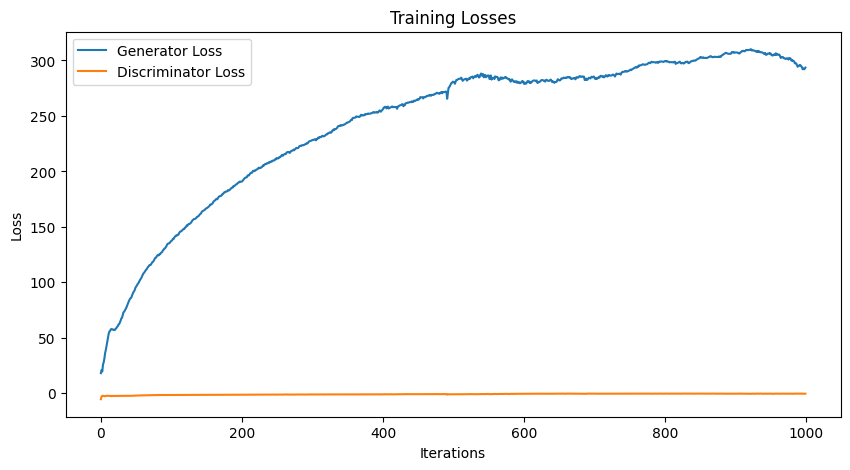

In [43]:
# Plot training losses
plt.figure(figsize=(10,5))
plt.plot(G_losses, label="Generator Loss")
plt.plot(D_losses, label="Discriminator Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.title("Training Losses")
plt.show()

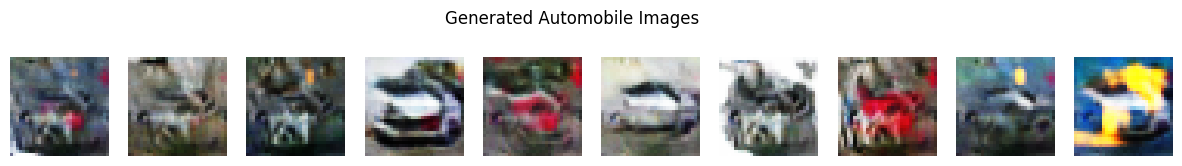

In [22]:
# %%
# Generate and display 10 images for the 'automobile' class
# In CIFAR10, the 'automobile' class has label 1.
generator.eval()
n_samples = 10
with torch.no_grad():
    noise = torch.randn(n_samples, latent_dim, device=device)
    labels = torch.full((n_samples,), 1, dtype=torch.long, device=device)  # label 1 for automobile
    gen_imgs = generator(noise, labels)
    # Denormalize images from [-1,1] to [0,1]
    gen_imgs = (gen_imgs + 1) / 2.0

# Plot the images
fig, axs = plt.subplots(1, n_samples, figsize=(15,2))
for i in range(n_samples):
    axs[i].imshow(np.transpose(gen_imgs[i].cpu().numpy(), (1,2,0)))
    axs[i].axis('off')
plt.suptitle("Generated Automobile Images")
plt.show()

In [23]:
# %%
# Compute Inception Score (IS) and FID using torchmetrics
generator.eval()
num_eval_samples = 1000
eval_batch = 50
gen_imgs_all = []

In [24]:
for _ in range(num_eval_samples // eval_batch):
    noise = torch.randn(eval_batch, latent_dim, device=device)
    # generate images for the 'automobile' class (label 1)
    labels = torch.full((eval_batch,), 1, dtype=torch.long, device=device)
    gen_batch = generator(noise, labels)
    # Denormalize to [0,1]
    gen_batch = (gen_batch + 1) / 2.0
    gen_imgs_all.append(gen_batch)
gen_imgs_all = torch.cat(gen_imgs_all, dim=0)

In [25]:
num_eval_samples = 200
eval_batch = 50
gen_imgs_all = []

for _ in range(num_eval_samples // eval_batch):
    noise = torch.randn(eval_batch, latent_dim, device=device)
    # Provide the label for each sample; here we're using label '1' for automobiles
    labels = torch.full((eval_batch,), 1, dtype=torch.long, device=device)
    gen_batch = generator(noise, labels)
    gen_batch = (gen_batch + 1) / 2.0  # Denormalize from [-1,1] to [0,1]
    # Convert to uint8 as required by the metric
    gen_batch_uint8 = (gen_batch * 255).clamp(0, 255).to(torch.uint8)
    gen_imgs_all.append(gen_batch_uint8)

gen_imgs_all = torch.cat(gen_imgs_all, dim=0)

inception_metric = InceptionScore()
inception_metric.update(gen_imgs_all.cpu())
inception_score = inception_metric.compute()

/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `InceptionScore` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
Downloading: "https://github.com/toshas/torch-fidelity/releases/download/v0.2.0/weights-inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/weights-inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:00<00:00, 182MB/s]


In [26]:
inception_score = inception_metric.compute()
score_mean, score_std = inception_score
print(f"Inception Score (IS): {score_mean.item():.4f} ± {score_std.item():.4f}")

Inception Score (IS): 2.7391 ± 0.3634


In [27]:
# For FID, we need real images from the same class.
real_imgs = []
for img, label in train_dataset:
    if label == 1:  # 'automobile'
        real_imgs.append(img.unsqueeze(0))
real_imgs = torch.cat(real_imgs, dim=0)
# Denormalize: our transform normalized images to [-1,1], so re-scale to [0,1]
real_imgs = (real_imgs + 1) / 2.0
# If too many, sample a subset (e.g., num_eval_samples images)
if real_imgs.size(0) > num_eval_samples:
    idx = np.random.choice(real_imgs.size(0), num_eval_samples, replace=False)
    real_imgs = real_imgs[idx]
real_imgs = real_imgs.to(device)

# Convert real_imgs to uint8 as expected by the metric
real_imgs_uint8 = (real_imgs * 255).clamp(0, 255).to(torch.uint8)

fid_metric = FrechetInceptionDistance().to(device)


In [28]:
# Update with real images
fid_metric.update(real_imgs_uint8, real=True)

In [29]:
# Update with generated images
fid_metric.update(gen_imgs_all, real=False)
fid_score = fid_metric.compute()
print(f"Fréchet Inception Distance (FID): {fid_score.item():.4f}")

Fréchet Inception Distance (FID): 210.5218
